# Hyper Parameter Tuning using RandomizedSearchCV

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Convert columns to numeric, coercing errors to NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['date' 'classification']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['date' 'classification']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [2]:
import pandas as pd

# Define the path to the CSV file
csv_path = 'tables/notebook06/results.csv'

# Read the DataFrame from the CSV file
results_df = pd.read_csv(csv_path)

print("DataFrame loaded from CSV:")
print(results_df)


DataFrame loaded from CSV:
             Model          RMSE       MAPE
0        SimpleRNN   5376.405362  19.692222
1             LSTM   7692.803221  31.045403
2              GRU  11582.438217  47.736083
3  Sequential LSTM   4149.896273  16.583052
4  Timeseries LSTM   8603.788989  35.633090


## Function to Save Models

In [3]:
import os
import pickle
from datetime import datetime

def save_model_and_scalers(model, scaler_X, scaler_y, model_type):
    """
    Save the Keras model and scalers with a timestamp and type in a directory using pickle.

    Parameters:
    - model: The trained Keras model to be saved.
    - scaler_X: The MinMaxScaler object for the features.
    - scaler_y: The MinMaxScaler object for the target variable.
    - model_type: A string representing the type of the model (e.g., "RNN", "LSTM").
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"saved_models/{model_type}"  # Create a directory with the model name
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_filename = f"{save_dir}/{model_type}_model_{timestamp}.h5"
    model.save(model_filename)

    # Save the scalers
    scalers_filename = f"{save_dir}/{model_type}_scalers_{timestamp}.pkl"
    with open(scalers_filename, 'wb') as f:
        pickle.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f)

    print(f"Model saved to {model_filename}")
    print(f"Scalers saved to {scalers_filename}")

## Imports

## Random Search

In [4]:
import numpy as np
import math
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
import pandas as pd
import os

# Assuming the following variables are defined and properly prepared:
# X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler_y

n_input = 168  # Number of time steps to look back for predictions
n_features = X_train_scaled.shape[1]  # Number of features in the dataset

def objective(trial):
    # Hyperparameters to be tuned
    units = trial.suggest_categorical('units', [50, 100, 150])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Model definition
    model = Sequential([
        LSTM(units=units, activation=activation, input_shape=(n_input, n_features)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Fit model using TimeseriesGenerator
    train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=batch_size)
    validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=batch_size)
    model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=0)
    
    # Evaluate the model
    val_loss = model.evaluate(validation_generator, verbose=0)
    return val_loss

# Optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# After optimization, print best parameters
best_params = study.best_trial.params
print(f"Best parameters: {best_params}")

# Correct approach to use the best parameters to create a new model
model = Sequential([
    LSTM(units=best_params['units'], activation=best_params['activation'], input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')

# It's suggested to retrain our model here with the entire dataset or a combined train-validation set if applicable
# Adjust batch_size based on best_params if it was part of the optimization
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=best_params['batch_size'])
model.fit(train_generator, epochs=10, verbose=1)  # Or more epochs as needed

# Save the model and scalers after retraining
save_model_and_scalers(model, scaler_X, scaler_y, "LSTM_Optimized")

validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=best_params['batch_size'])
y_pred_scaled = model.predict(validation_generator)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Now that y_pred is defined, adjust the length of y_test_original accordingly
y_test_original = y_test.values.flatten()[:len(y_pred)]

# Calculate RMSE and MAPE
rmse = math.sqrt(mean_squared_error(y_test_original, y_pred))
mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")



/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2024-06-29 00:25:04,706] A new study created in memory with name: no-name-f36c6fad-cc3e-4752-aeb9-ca0d711e2948


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2024-06-29 00:25:31,799] Trial 0 finished with value: 0.03005089983344078 and parameters: {'units': 150, 'activation': 'relu', 'learning_rate': 0.0001158754231768636, 'batch_size': 64}. Best is trial 0 with value: 0.03005089983344078.
[I 2024-06-29 00:26:06,887] Trial 1 finished with value: 0.006931318901479244 and parameters: {'units': 150, 'activation': 'tanh', 'learning_rate': 0.0005075141280970885, 'batch_size': 32}. Best is trial 1 with value: 0.006931318901479244.
[I 2024-06-29 00:26:26,822] Trial 2 finished with value: 0.0030235450249165297 and parameters: {'units': 100, 'activation': 'relu', 'learning_rate': 0.00035586639776387374, 'batch_size': 64}. Best is trial 2 with value: 0.0030235450249165297.
[I 2024-06-29 00:26:48,502] Trial 3 finished with value: 0.00692305201664567 and parameters: {'units': 150, 'activation': 'relu', 'learning_rate': 0.0023407399830204373, 'batch_size': 128}. Best is trial 2 with value: 0.0030235450249165297.
[I 2024-06-29 00:26:58,765] Trial 4 fi

Model saved to saved_models/LSTM_Optimized/LSTM_Optimized_model_20240629_002902.h5
Scalers saved to saved_models/LSTM_Optimized/LSTM_Optimized_scalers_20240629_002902.pkl
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
RMSE: 5090.08726214225
MAPE: 21.0613564772383%


In [5]:

# Add the results to the DataFrame
results_df = pd.read_csv('tables/notebook06/results.csv')
new_result = pd.DataFrame({'Model': ['LSTM_Optimized'], 'RMSE': [rmse], 'MAPE': [mape]})
results_df = pd.concat([results_df, new_result], ignore_index=True)

# Create the directory if it doesn't exist
output_dir = 'tables/notebook07'
os.makedirs(output_dir, exist_ok=True)

# Save the updated DataFrame
results_df.to_csv(os.path.join(output_dir, 'results.csv'), index=False)
results_df.to_latex(os.path.join(output_dir, 'results.tex'), index=False)

In [6]:
import pandas as pd

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_test_path = base_path + 'X_test.csv'

# Re-read the X_test data from the file
X_test = pd.read_csv(X_test_path)

# Ensure the datetime column is present
if 'datetime' not in X_test.columns:
    X_test['datetime'] = pd.to_datetime(X_test.index)

print("Available columns in X_test after adding datetime:", X_test.columns)


Available columns in X_test after adding datetime: Index(['date', 'open', 'volume', 'sma_30', 'rsi', 'macd', 'dia_close',
       'dia_volume', 'gld_close', 'gld_volume', 'spy_close', 'spy_volume',
       'federal_funds_rate_daily', 'treasury_yield_daily', 'cpi_monthly',
       'durables_monthly', 'nonfarm_payroll_monthly',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'unemployment_monthly',
       'central_bank_policy_rate_prcnt', 'domestic_credit_gdp',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'inflation_rate_value',
       'individuals_using_the_internet_prcnt_of_population',
       'mobile_cellular_subscriptions_per_100_people',
       'personal_remittances_received_prcnt_of_gdp',
       'stock_market_index_value', 'tariffs_value',
       'total_public_debt_gdp_value', 'trade_balance_value',
       'trade_in_services_value', 'unemployment_rate_value', 'value',
       'classification_numerical', 'classi

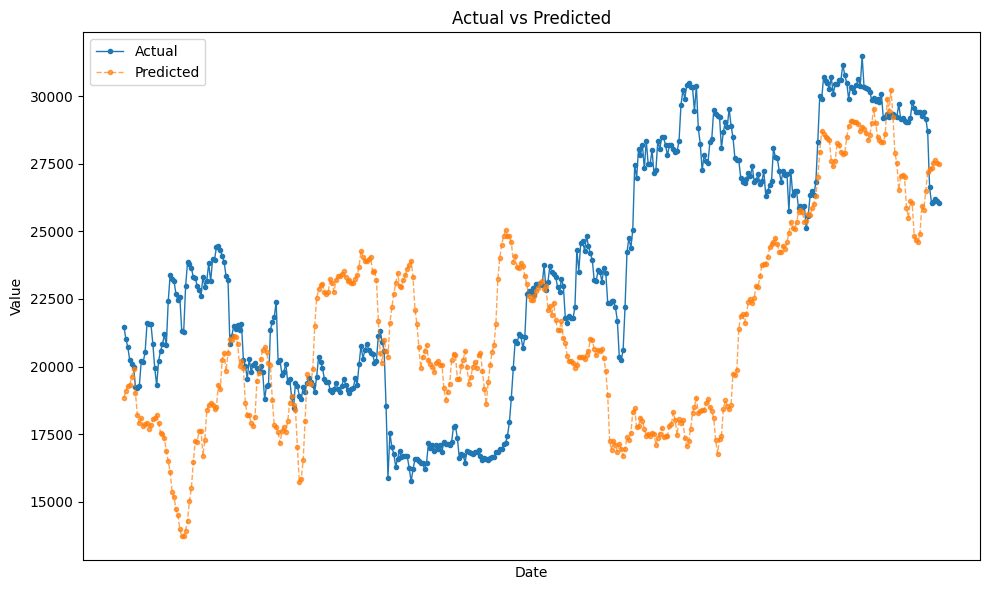

Plot saved to figures/notebook07/actual_vs_predicted07.png


In [7]:
import matplotlib.pyplot as plt
import os

y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
# Assuming y_test_original and y_pred are correctly aligned with these dates
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve readability of the date labels
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot to the specified directory
output_dir = 'figures/notebook07'
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, 'actual_vs_predicted07.png')
plt.savefig(plot_path, bbox_inches='tight')

# Show the plot
plt.show()

print(f"Plot saved to {plot_path}")
